# Project for CS545

Sam Armstrong, Saloni Choudhary, Brandon Hua

In [1]:
import pandas as pd
import datetime
# univariate stacked lstm example
# from numpy import array
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

## Get Data


In [2]:
# Run these pip3 installs once to install yahoo finance libraries
# !pip3 install yahoo-finance --user
# !pip3 install yfinance --user --upgrade --no-cache-dir

import yfinance as yf
# Documentation at https://pypi.org/project/yfinance/

In [3]:
tickers = 'aapl msft'
# exclude dwdp because it's historical data only goes back 1 year
period = '5y'

data = yf.download(tickers, period=period)
data.columns = ['%s%s' % (a, ' %s' % b if b else '') for a, b in data.columns]
data[data.isna().any(axis=1)] #Display rows with Null values

[*********************100%***********************]  2 of 2 downloaded


,Adj Close AAPL,Adj Close MSFT,Close AAPL,Close MSFT,High AAPL,High MSFT,Low AAPL,Low MSFT,Open AAPL,Open MSFT,Volume AAPL,Volume MSFT
Date,,,,,,,,,,,,


In [4]:
#data = data.drop([datetime.datetime(2016, 1, 18)])
data.shape

(1259, 12)

## Data

The data comprises of 29 stocks [mmm axp aapl ba cat cvx csco ko dis xom ge gs hd ibm intc jnj jpm mcd mrk msft nke pfe pg trv utx unh vz v wmt] over a 5 year period (end date is current date) with 252 days in a year (except 2016 whichis missing the date 2016-01-18). Each date entry has 6 variables [Adjusted Close, Close, High, Low, Open, Volume]. We are trying to predict the next day's Close. 

In [5]:
AAPL = data[['Close AAPL', 'High AAPL', 'Low AAPL', 'Open AAPL', 'Volume AAPL']]
MSFT = data[['Close MSFT', 'High MSFT', 'Low MSFT', 'Open MSFT', 'Volume MSFT']]

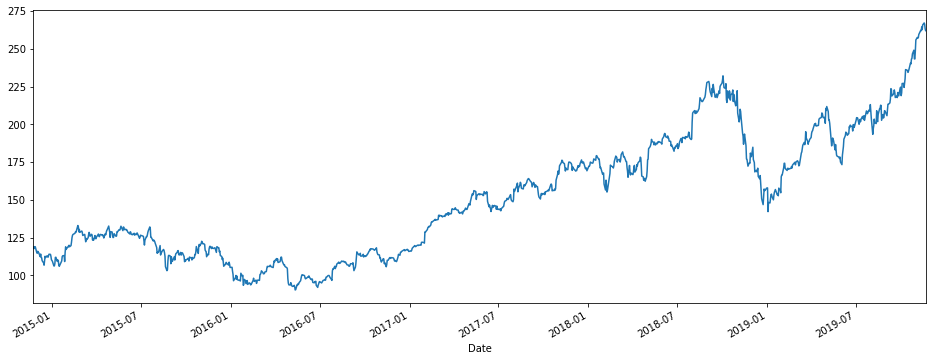

In [6]:
AAPL['Close AAPL'].plot(figsize=(16,6))

## Setting Up the Data

In [61]:
def setup(look_back, data):
    train_percent = .8
    n_train = int(train_percent * len(data))
    train = data[:n_train]
    test = data[n_train - look_back:]
    return train, test

def partition_data(train_scaled, test_scaled, look_back):
    X_train = []
    y_train = []
    X_test = []
    for i in range(look_back, train_scaled.shape[0]):
        X_train.append(train_scaled[i-look_back:i, :])
        y_train.append(train_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    # Reshaping
#     X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    
    for i in range(look_back, test_scaled.shape[0]):
        X_test.append(test_scaled[i-look_back:i, :])
    X_test = np.array(X_test)
#     X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))
    return X_train, y_train, X_test
def plot(predicted, y):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.plot(predicted)
    plt.plot(y)
    
    plt.subplot(2, 1, 2)
    rse = np.sqrt((predicted - y)**2)
    plt.plot(rse)
    plt.show()
    
    rmse = np.mean(rse)
    print('RMSE: %.2f' % rmse)

## Multivariate Model

In [62]:
look_back = 1

train_percent = .8
n_train = int(train_percent * len(AAPL))

train, test = setup(look_back, AAPL)
# Feature Scaling
scMultiVariate = MinMaxScaler(feature_range = (0, 1))
train_scaled = scMultiVariate.fit_transform(train)
test_scaled = scMultiVariate.transform(test.to_numpy())

Y_test = test['Close AAPL'][look_back:].to_numpy().reshape(-1,1)

X_train, y_train, X_test, = partition_data(train_scaled, test_scaled, look_back)

In [63]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

In [64]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)

Train on 1006 samples
Epoch 1/10
1006/1006 [==============================] - 9s 9ms/sample - loss: 0.1267
Epoch 2/10
1006/1006 [==============================] - 0s 400us/sample - loss: 0.0224
Epoch 3/10
1006/1006 [==============================] - 1s 697us/sample - loss: 0.0060
Epoch 4/10
1006/1006 [==============================] - 1s 697us/sample - loss: 0.0031
Epoch 5/10
1006/1006 [==============================] - 1s 704us/sample - loss: 0.0031
Epoch 6/10
1006/1006 [==============================] - 1s 706us/sample - loss: 0.0024
Epoch 7/10
1006/1006 [==============================] - 1s 695us/sample - loss: 0.0022
Epoch 8/10
1006/1006 [==============================] - 1s 701us/sample - loss: 0.0020
Epoch 9/10
1006/1006 [==============================] - 1s 712us/sample - loss: 0.0021s - lo
Epoch 10/10
1006/1006 [==============================] - 1s 701us/sample - loss: 0.0020


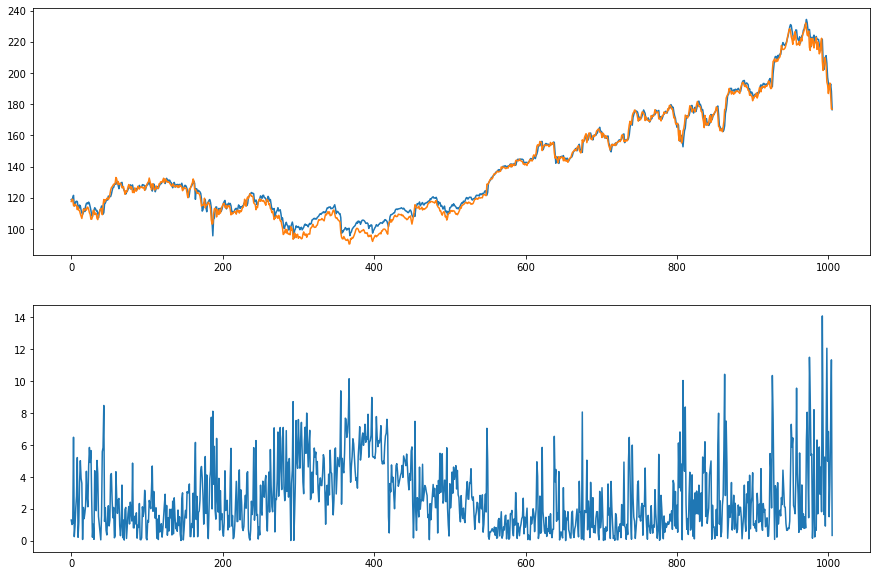

RMSE: 2.68


In [65]:
predicted_stock_price = regressor.predict(X_train)
predicted_stock_price = scMultiVariate.inverse_transform(np.repeat(predicted_stock_price, X_train.shape[2], axis=1))[:, 1]
predicted_stock_price = pd.DataFrame(predicted_stock_price)

plot(predicted_stock_price, Y_train)


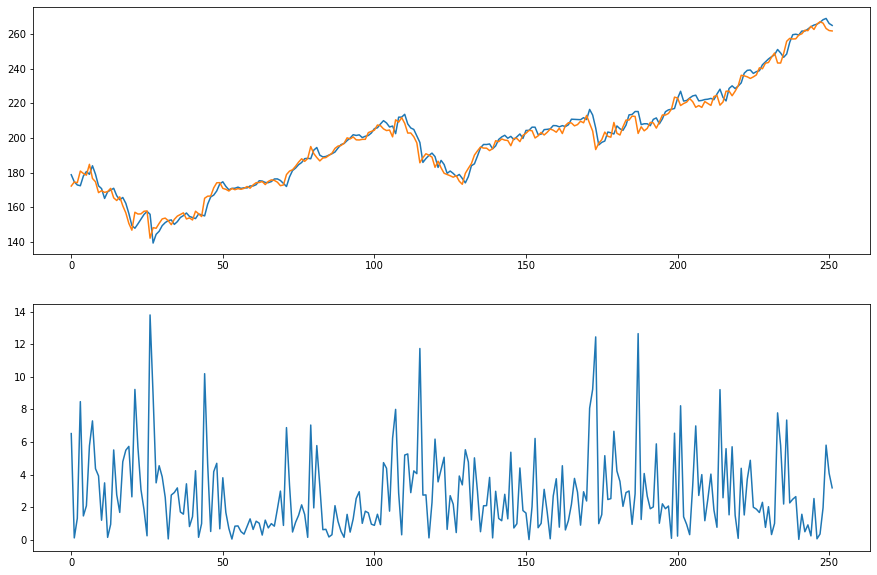

RMSE: 2.85


In [68]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scMultiVariate.inverse_transform(np.repeat(predicted_stock_price, X_test.shape[2], axis=1))[:, 1]
predicted_stock_price = pd.DataFrame(predicted_stock_price)

plot(predicted_stock_price, Y_test)

## Multi-Series Multivariate Model

In [54]:
look_back = 1

scSeries = MinMaxScaler(feature_range = (0, 1))
scSeries2 = MinMaxScaler(feature_range = (0, 1))

multi_series_data = pd.concat([AAPL, MSFT], axis=1)

print(multi_series_data.shape)
multivariate_seqs = scSeries.fit_transform(multi_series_data)
multivariate_sols = scSeries2.fit_transform(data["Close AAPL"].to_numpy().reshape(-1, 1))


train_percent = .8
n_train = int(train_percent * len(multivariate_seqs))
training_set = multivariate_seqs[:n_train]
Y_train = multivariate_sols[look_back:n_train]
testing_set = multivariate_seqs[n_train - look_back:]
Y_test = multivariate_sols[n_train:]

X_train = []
y_train = []
for i in range(look_back, training_set.shape[0]):
    X_train.append(training_set[i-look_back:i, :])
X_train = np.array(X_train)

(1259, 10)


In [55]:
# Initialising the RNN
regressor = Sequential()

regressor.add(TimeDistributed(Conv1D(filters=100, kernel_size=1, activation='relu'), input_shape=(None, look_back, 10)))
# regressor.add(Dropout(0.5))
regressor.add(TimeDistributed(MaxPooling1D(pool_size=1)))
# regressor.add(Dropout(0.5))
regressor.add(TimeDistributed(Flatten()))
regressor.add(Dropout(0.2))
regressor.add(LSTM(200, return_sequences = True, activation='relu'))
regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1, activation='relu'))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]), Y_train, epochs = 10)


Train on 1006 samples
Epoch 1/10
1006/1006 [==============================] - 3s 3ms/sample - loss: 0.0301
Epoch 2/10
1006/1006 [==============================] - 0s 231us/sample - loss: 0.0030
Epoch 3/10
1006/1006 [==============================] - 0s 279us/sample - loss: 0.0019
Epoch 4/10
1006/1006 [==============================] - 0s 448us/sample - loss: 0.0015
Epoch 5/10
1006/1006 [==============================] - 0s 448us/sample - loss: 0.0014
Epoch 6/10
1006/1006 [==============================] - 0s 319us/sample - loss: 0.0014
Epoch 7/10
1006/1006 [==============================] - 0s 246us/sample - loss: 0.0014
Epoch 8/10
1006/1006 [==============================] - 0s 311us/sample - loss: 0.0015
Epoch 9/10
1006/1006 [==============================] - 0s 317us/sample - loss: 0.0014
Epoch 10/10
1006/1006 [==============================] - 0s 308us/sample - loss: 0.0012


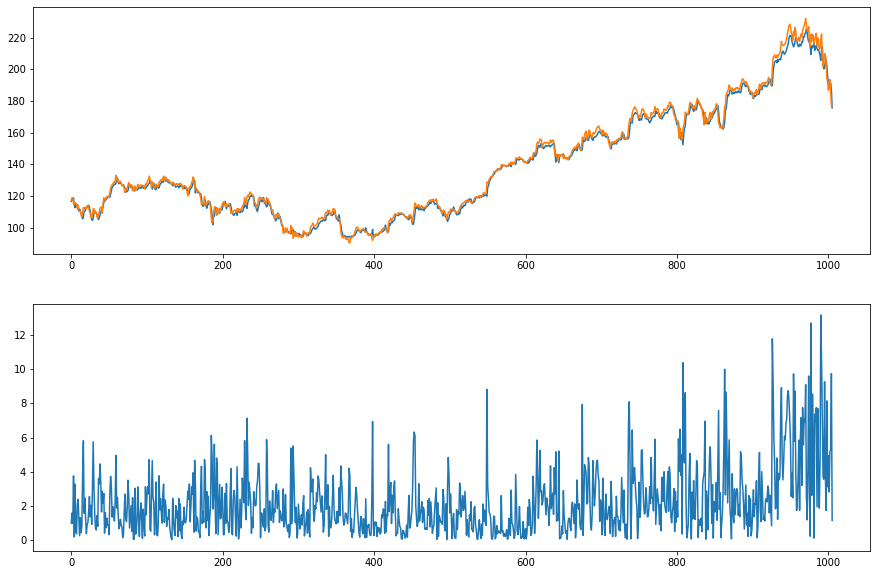

In [56]:
predicted_stock_price = regressor.predict(X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])).reshape(-1, 1)
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)

predicted_stock_price = scSeries2.inverse_transform(predicted_stock_price)
Y_train = scSeries2.inverse_transform(Y_train)
plt.plot(predicted_stock_price)
plt.plot(Y_train)

plt.subplot(2, 1, 2)
rse = np.sqrt((predicted_stock_price - Y_train)**2)
plt.plot(rse)

plt.show()

In [57]:
rmse = np.mean(rse)
print('RMSE: %.2f' % rmse)
plt.show()

RMSE: 2.19


In [58]:
X_test = []
for i in range(look_back, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back:i, :])

X_test = np.array(X_test)
# Use the following line for convNN
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
# predicted_stock_price = regressor.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).reshape(-1, 1)
predicted_stock_price = regressor.predict(X_test).reshape(-1, 1)

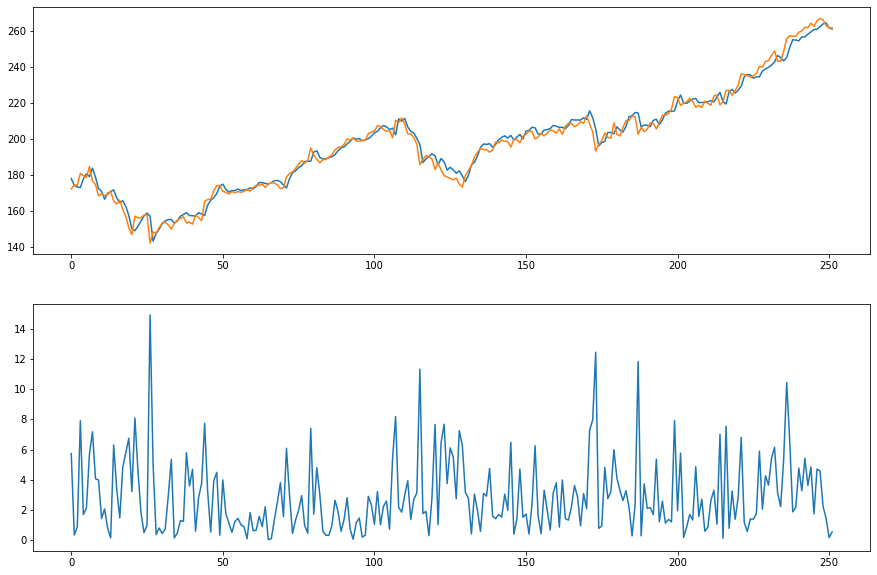

In [59]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
predicted_stock_price = scSeries2.inverse_transform(predicted_stock_price)
Y_test = scSeries2.inverse_transform(Y_test)
plt.plot(predicted_stock_price)
plt.plot(Y_test)

plt.subplot(2, 1, 2)
rse = np.sqrt((predicted_stock_price - Y_test)**2)
plt.plot(rse)

In [60]:
rmse = np.mean(rse)
print('RMSE: %.2f' % rmse)
plt.show()

RMSE: 2.89


## Multi-Series 2-Dimensional Multivariate Model

In [20]:
look_back = 1
scSeries = MinMaxScaler(feature_range = (0, 1))
scSeries2 = MinMaxScaler(feature_range = (0, 1))

multi_series_data = pd.concat([AAPL, MSFT], axis=1)

multivariate_seqs = scSeries.fit_transform(multi_series_data)
multivariate_sols = scSeries2.fit_transform(data["Close AAPL"].to_numpy().reshape(-1, 1))

train_percent = .8
n_train = int(train_percent * len(multivariate_seqs))
training_set = multivariate_seqs[:n_train]
training_set = training_set.reshape(training_set.shape[0], 1, 2, 5)
Y_train = multivariate_sols[look_back:n_train]
testing_set = multivariate_seqs[n_train - look_back:]
testing_set = testing_set.reshape(testing_set.shape[0], 1, 2, 5)
Y_test = multivariate_sols[n_train:]

X_train = []
y_train = []
for i in range(look_back, training_set.shape[0]):
    X_train.append(training_set[i-look_back:i, :, :])
X_train = np.array(X_train)

In [21]:
# Initialising the RNN
regressor = Sequential()
regressor.add(ConvLSTM2D(filters=200, kernel_size=(1,2), activation='relu', input_shape=(look_back, 1, 2, 5)))
regressor.add(Flatten())

# regressor.add(Dropout(.2))

regressor.add(Dense(1, activation='relu'))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, Y_train, epochs = 10)


Train on 1006 samples
Epoch 1/10
1006/1006 [==============================] - 4s 4ms/sample - loss: 0.0537
Epoch 2/10
1006/1006 [==============================] - 0s 334us/sample - loss: 0.0056
Epoch 3/10
1006/1006 [==============================] - 0s 339us/sample - loss: 0.0022
Epoch 4/10
1006/1006 [==============================] - 0s 338us/sample - loss: 0.0013
Epoch 5/10
1006/1006 [==============================] - 0s 328us/sample - loss: 0.0010
Epoch 6/10
1006/1006 [==============================] - 0s 337us/sample - loss: 7.1575e-04
Epoch 7/10
1006/1006 [==============================] - 0s 337us/sample - loss: 4.7029e-04
Epoch 8/10
1006/1006 [==============================] - 0s 326us/sample - loss: 3.2222e-04
Epoch 9/10
1006/1006 [==============================] - 0s 322us/sample - loss: 2.3902e-04
Epoch 10/10
1006/1006 [==============================] - 0s 328us/sample - loss: 2.0114e-04


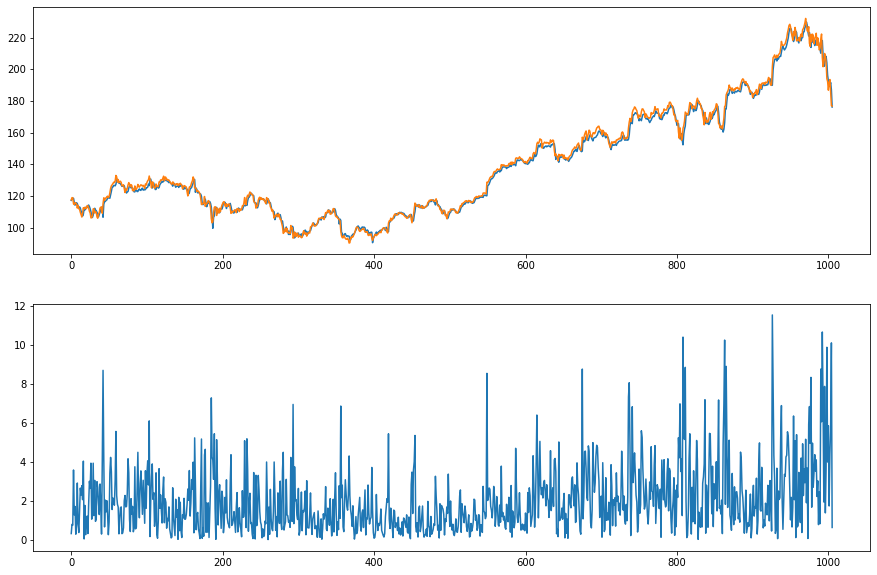

In [22]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
predicted_stock_price = regressor.predict(X_train.reshape(X_train.shape[0], look_back, 1, 2, 5)).reshape(-1, 1)
predicted_stock_price = scSeries2.inverse_transform(predicted_stock_price)
Y_train = scSeries2.inverse_transform(Y_train)
plt.plot(predicted_stock_price)
plt.plot(Y_train)

plt.subplot(2, 1, 2)
rse = np.sqrt((predicted_stock_price - Y_train)**2)
plt.plot(rse)

In [23]:
rmse = np.mean(rse)
print('RMSE: %.2f' % rmse)
plt.show()

RMSE: 2.00


In [24]:
X_test = []
for i in range(look_back, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back:i, :])

X_test = np.array(X_test)
# Use the following line for convNN
X_test = X_test.reshape(X_test.shape[0], look_back, 1, 2, 5)
# predicted_stock_price = regressor.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).reshape(-1, 1)
predicted_stock_price = regressor.predict(X_test).reshape(-1, 1)

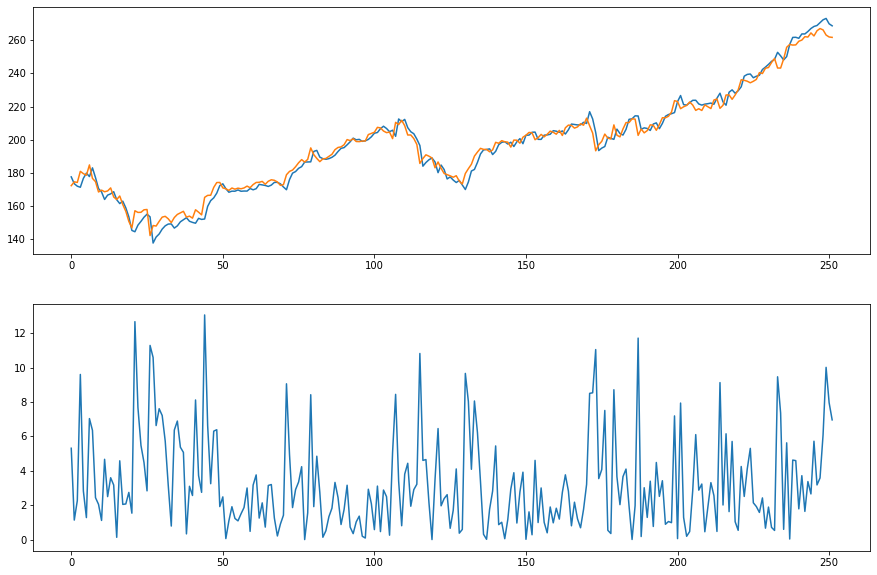

In [25]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
predicted_stock_price = scSeries2.inverse_transform(predicted_stock_price)
Y_test = scSeries2.inverse_transform(Y_test)
plt.plot(predicted_stock_price)
plt.plot(Y_test)

plt.subplot(2, 1, 2)
rse = np.sqrt((predicted_stock_price - Y_test)**2)
plt.plot(rse)

In [26]:
rmse = np.mean(rse)
print('RMSE: %.2f' % rmse)
plt.show()

RMSE: 3.27


# Multivariate GRU

In [27]:
look_back = 1

scSeries = MinMaxScaler(feature_range = (0, 1))
scSeries2 = MinMaxScaler(feature_range = (0, 1))

multi_series_data = pd.concat([AAPL, MSFT], axis=1)

print(multi_series_data.shape)
multivariate_seqs = scSeries.fit_transform(multi_series_data)
multivariate_sols = scSeries2.fit_transform(data["Close AAPL"].to_numpy().reshape(-1, 1))


train_percent = .8
n_train = int(train_percent * len(multivariate_seqs))
training_set = multivariate_seqs[:n_train]
Y_train = multivariate_sols[look_back:n_train]
testing_set = multivariate_seqs[n_train - look_back:]
Y_test = multivariate_sols[n_train:]

X_train = []
y_train = []
for i in range(look_back, training_set.shape[0]):
    X_train.append(training_set[i-look_back:i, :])
X_train = np.array(X_train)

X_test = []
for i in range(look_back, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back:i, :])
X_test = np.array(X_test)

X_test = np.array(X_test)
# Use the following line for convNN
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

(1259, 10)


Train on 1006 samples
Epoch 1/10
1006/1006 [==============================] - 6s 6ms/sample - loss: 0.0301
Epoch 2/10
1006/1006 [==============================] - 0s 288us/sample - loss: 0.0043
Epoch 3/10
1006/1006 [==============================] - 0s 402us/sample - loss: 0.0023
Epoch 4/10
1006/1006 [==============================] - 1s 503us/sample - loss: 0.0019
Epoch 5/10
1006/1006 [==============================] - 1s 498us/sample - loss: 0.0018
Epoch 6/10
1006/1006 [==============================] - 1s 543us/sample - loss: 0.0015
Epoch 7/10
1006/1006 [==============================] - 1s 560us/sample - loss: 0.0013
Epoch 8/10
1006/1006 [==============================] - 1s 535us/sample - loss: 0.0012
Epoch 9/10
1006/1006 [==============================] - 1s 550us/sample - loss: 0.0011
Epoch 10/10
1006/1006 [==============================] - 1s 551us/sample - loss: 0.0011


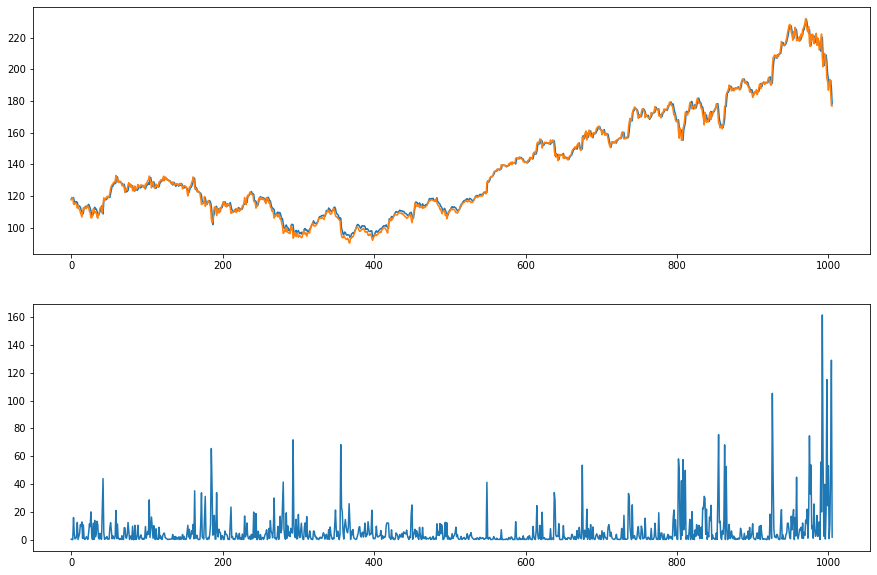

In [28]:
regressor = Sequential()
regressor.add(GRU(units=40,
              return_sequences=True,
              input_shape=(X_train.shape[1],10)))
regressor.add(Dropout(0.1))
regressor.add(GRU(units=40))
regressor.add(Dropout(0.1))
regressor.add(Dense(1))
regressor.compile(loss='mse', optimizer='adam')

# Fitting the RNN to the Training set
history = regressor.fit(X_train, Y_train, epochs = 10)
predicted_stock_price = regressor.predict(X_train).reshape(-1, 1)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
predicted_stock_price = scSeries2.inverse_transform(predicted_stock_price)
Y_train = scSeries2.inverse_transform(Y_train)
plt.plot(predicted_stock_price)
plt.plot(Y_train)

plt.subplot(2, 1, 2)
rse = (predicted_stock_price - Y_train)**2
plt.plot(rse)


In [29]:
rmse = np.mean(rse)
print('RMSE: %.2f' % rmse)
plt.show()

RMSE: 5.93


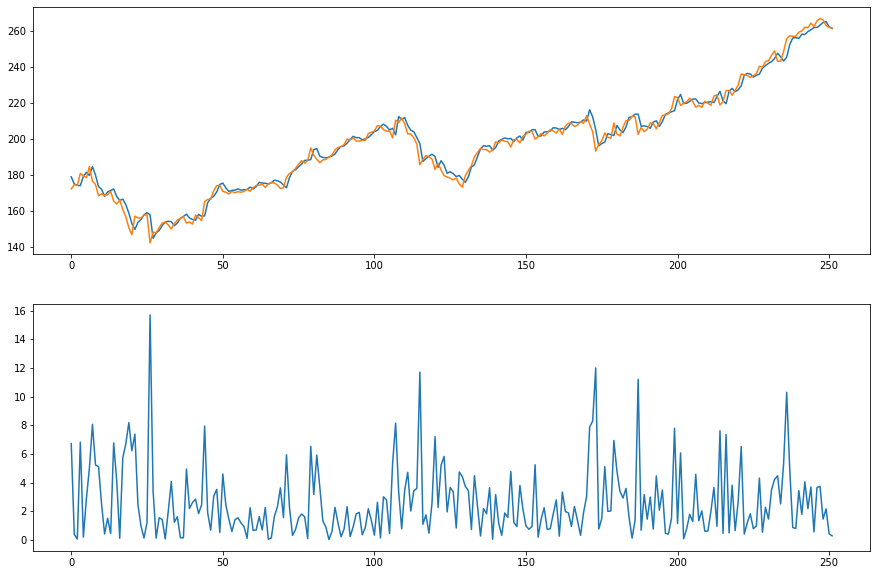

In [30]:
X_test = []
for i in range(look_back, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back:i, :])

X_test = np.array(X_test)
# Use the following line for convNN
# X_test = X_test.reshape(X_test.shape[0], look_back, 1, 2, 5)
# predicted_stock_price = regressor.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).reshape(-1, 1)
predicted_stock_price = regressor.predict(X_test).reshape(-1, 1)

# Fitting the RNN to the Training set
predicted_stock_price = regressor.predict(X_test).reshape(-1, 1)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
predicted_stock_price = scSeries2.inverse_transform(predicted_stock_price)
Y_test = scSeries2.inverse_transform(Y_test)
plt.plot(predicted_stock_price)
plt.plot(Y_test)

plt.subplot(2, 1, 2)
rse = np.sqrt((predicted_stock_price - Y_test)**2)
plt.plot(rse)


In [31]:
rmse = np.mean(rse)
print('RMSE: %.2f' % rmse)
plt.show()

RMSE: 2.65
